In [1]:
import pandas as pd
# data from zillow, average rent per month since 2014
url = 'https://files.zillowstatic.com/research/public_v2/zori/Metro_ZORI_AllHomesPlusMultifamily_SSA.csv'
df = pd.read_csv(url)
print(df.shape)
df.head()

(106, 88)


,RegionID,RegionName,SizeRank,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01
0,102001,United States,0,1373.0,1380.0,1388.0,1395.0,1402.0,1409,1417,1424,1431,1438,1445,1451,1458,1464,1469,1475,1481,1487,1492,1498,1504,1509,1515,1520,1525,1530,1535,1540,1545,1549,1554,1558,1563,1567,1571,1575,1579,...,1615,1620,1624,1629,1634,1639,1644,1649,1654,1659,1664,1669,1674,1679,1685,1690.0,1695.0,1700,1705,1710,1715,1720,1724,1729,1733,1736,1739,1742,1742,1743,1744,1745,1745,1746,1746,1747,1747,1747,1747.0,1748.0
1,394913,"New York, NY",1,2379.0,2391.0,2403.0,2415.0,2426.0,2438,2450,2462,2474,2485,2496,2507,2518,2527,2537,2546,2555,2564,2573,2580,2588,2595,2601,2607,2613,2618,2623,2628,2632,2636,2640,2644,2648,2652,2656,2660,2663,...,2691,2694,2697,2700,2703,2706,2710,2714,2719,2723,2728,2733,2738,2744,2750,2755.0,2761.0,2767,2773,2779,2785,2791,2795,2800,2804,2803,2801,2799,2785,2770,2756,2734,2713,2691,2669,2646,2624,2600,2576.0,2552.0
2,753899,"Los Angeles-Long Beach-Anaheim, CA",2,1831.0,1848.0,1865.0,1882.0,1899.0,1916,1932,1949,1965,1982,1996,2010,2024,2036,2047,2059,2071,2083,2094,2107,2119,2131,2143,2156,2168,2180,2191,2203,2213,2224,2235,2245,2255,2265,2275,2285,2295,...,2376,2384,2392,2400,2408,2417,2425,2434,2443,2452,2460,2468,2477,2485,2492,2500.0,2508.0,2515,2522,2529,2536,2543,2549,2555,2561,2563,2566,2568,2568,2567,2566,2565,2564,2563,2561,2559,2558,2556,2554.0,2553.0
3,394463,"Chicago, IL",3,1511.0,1517.0,1522.0,1528.0,1533.0,1539,1544,1549,1554,1559,1564,1568,1573,1577,1581,1584,1589,1593,1597,1602,1607,1612,1618,1623,1629,1633,1637,1641,1645,1648,1651,1654,1657,1659,1662,1665,1667,...,1690,1692,1695,1697,1700,1703,1706,1709,1712,1715,1718,1721,1725,1728,1732,1736.0,1740.0,1744,1748,1753,1757,1761,1765,1768,1771,1772,1773,1774,1771,1769,1766,1762,1758,1754,1750,1746,1742,1737,1732.0,1728.0
4,394514,"Dallas-Fort Worth, TX",4,1199.0,1207.0,1214.0,1221.0,1229.0,1236,1243,1251,1258,1265,1272,1279,1285,1291,1297,1303,1308,1313,1319,1324,1330,1335,1341,1347,1352,1358,1364,1370,1376,1382,1388,1393,1398,1404,1409,1413,1418,...,1456,1460,1464,1468,1471,1475,1479,1483,1487,1491,1495,1499,1504,1508,1513,1518.0,1522.0,1527,1532,1536,1541,1545,1549,1552,1556,1558,1560,1561,1563,1564,1566,1568,1571,1573,1575,1577,1580,1582,1585.0,1587.0


In [2]:
# The next 2 cells are for cleaning the data. Zillow grouped a couple of cities
# together so I went through and separated them into separate city names
df.loc[102] = df.loc[2]
df.loc[103] = df.loc[2]
df.loc[104] = df.loc[4]
df.loc[105] = df.loc[16]
df.loc[106] = df.loc[4]
df.loc[107] = df.loc[21]
df.loc[108] = df.loc[14]
df.loc[109] = df.loc[7]
df.loc[110] = df.loc[36]
df.loc[111] = df.loc[17]
df.loc[112] = df.loc[31]
nat_avg = df.loc[0]

In [3]:
df.at[1, 'RegionName'] = 'New York City, NY'
df.at[2, 'RegionName'] = 'Los Angeles, CA'
df.at[102, 'RegionName'] = 'Long Beach, CA'
df.at[103, 'RegionName'] = 'Anaheim, CA'
df.at[4, 'RegionName'] = 'Dallas, TX'
df.at[104, 'RegionName'] = 'Fort Worth, TX'
df.at[106, 'RegionName'] = 'Arlington, TX'
df.at[8, 'RegionName'] = 'Miami, FL'
df.at[16, 'RegionName'] = 'Minneapolis, MN'
df.at[105, 'RegionName'] = 'St Paul, MN'
df.at[42, 'RegionName'] = 'Louisville, KY'
df.at[53, 'RegionName'] = 'Honolulu, HI'
df.at[31, 'RegionName'] = 'North Las Vegas, NV'
df.at[107, 'RegionName'] = 'Aurora, CO'
df.at[108, 'RegionName'] = 'Chandler, AZ'
df.at[109, 'RegionName'] = 'Arlington, VA'
df.at[110, 'RegionName'] = 'Chesapeake, VA'
df.at[111, 'RegionName'] = 'Chula Vista, CA'
df.at[112, 'RegionName'] = 'Las Vegas, NV'

In [4]:
# remove the national average from the data set
df = df.loc[1:].copy()

In [5]:
# functions for separating the 'RegionName' into city and state
def get_state_name(city):
  state = city.split(',')[1]
  state = state.strip()
  return state

def get_city_name(city):
  name = city.split(',')[0]
  name = name.split()
  result = name[0]
  for word in name[1:]:
    if word[0].isupper():
      result += ' '
      result += word
  return result

df['City'] = df['RegionName'].apply(get_city_name)
df['State'] = df['RegionName'].apply(get_state_name)

In [6]:
# add back in the national average
df.loc[0] = nat_avg
df = df.sort_index()

In [7]:
# fill values for city and state for the national average
df.at[0, 'City'] = 'United States'
df.at[0, 'State'] = 'United States'
# create city code column that is uniform across all data sets
df['city_code'] = df['City'].apply(lambda x: x.replace(' ', '_'))

In [8]:
# get the columns that we would use for the data base
final_columns = ['City', 'State', 'city_code', '2020-12']

In [9]:
final = df[final_columns]
final = final.rename({'2020-12': 'Dec Avg Rent'}, axis=1)
# fix a couple of city code values
final.at[18, 'city_code'] = 'St_Louis'
final.at[77, 'city_code'] = 'WinstonSalem'
final.shape

(113, 4)

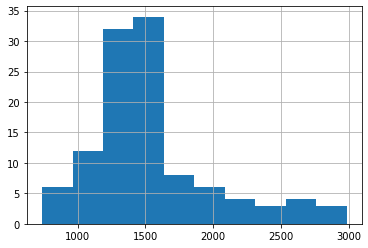

In [10]:
final['Dec Avg Rent'].hist();

In [ ]:
buckets = final['Dec Avg Rent'].quantile([0, .2, .4, .6, .8, 1]).values
buckets

array([ 742. , 1237.2, 1384.4, 1547. , 1764.6, 2993. ])

In [11]:
# this function is for creating the rent score
# returns a 1-5 value based on the above quantiles of the data
def rent_score(avg_rent):
    buckets = [ 742. , 1203.6, 1364. , 1535.6, 1721.2, 2993. ]
    if buckets[0] <= avg_rent <= buckets[1]:
        score = 5
    elif avg_rent <= buckets[2]:
        score = 4
    elif avg_rent <= buckets[3]:
        score = 3
    elif avg_rent <= buckets[4]:
        score = 2
    elif avg_rent <= buckets[5]:
        score = 1
    return score

In [12]:
final.loc[32, 'Dec Avg Rent'] = 1346

In [13]:
x = pd.Series([rent_score(rent) for rent in final['Dec Avg Rent']])
x.value_counts()

1    25
4    23
3    23
5    21
2    21
dtype: int64

In [ ]:
# download csv file to load it into the database
final.to_csv('cityspire_rent.csv', index=False)